# **FNN**
- Using data that was not annotated
- Training it on the unbalanced data
- Using avgpool
- 6 second window

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
# Standard libraries
import numpy as np
import pandas as pd
import time
import os

# For audio
from IPython.display import Audio
import librosa

# For preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf

# For modeling
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Operational
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import scipy.ndimage
import pygame
import time
from scipy.signal import butter, filtfilt
import random

In [22]:
pkl_path = '/content/drive/My Drive/Final-Year-Project/Dataset/Project-V4/feature-extraction/NotAnnotated/AveragePooled/split_features_6s_all.pkl'

# Load the pickle file
with open(pkl_path, 'rb') as file:
    data = pickle.load(file)

In [23]:
train_data = data['train'].copy()
val_data = data['val'].copy()

In [24]:
train_data

{'melspectrogram': array([[1.1545551e-05, 1.2176995e-05, 1.3009772e-05, ..., 4.4375400e-07,
         2.2230227e-08, 1.8851988e-08],
        [8.5422990e-08, 9.0774186e-08, 1.0014884e-07, ..., 1.3420139e-06,
         4.4213351e-07, 4.1396237e-07],
        [6.1857563e-06, 6.2330437e-06, 6.3144412e-06, ..., 1.1637738e-06,
         1.5971284e-07, 1.3454519e-07],
        ...,
        [7.1480241e-07, 7.4554231e-07, 7.9745979e-07, ..., 1.4340408e-06,
         1.3201277e-06, 1.2859776e-06],
        [6.0994887e-07, 6.2010758e-07, 6.3716243e-07, ..., 4.0761867e-07,
         1.7535218e-07, 1.6836647e-07],
        [6.8865182e-07, 6.9677486e-07, 7.1000841e-07, ..., 3.5803578e-06,
         1.9428686e-08, 1.4416809e-08]], dtype=float32),
 'mfcc': array([[-1.00000000e+00, -2.42030799e-01, -4.80754524e-01, ...,
          3.10237170e-03,  1.18157947e-02, -6.41129969e-04],
        [-1.00000000e+00, -2.10041642e-01, -3.97155881e-01, ...,
         -2.89330794e-03,  1.39303915e-02, -7.43062468e-03],
        

In [25]:
train_labels = train_data['label'].copy()
temp = train_data.copy()
del temp['label']
tr_features = temp

In [26]:
val_labels = val_data['label'].copy()
temp = val_data.copy()
del temp['label']
v_features = temp

# Shuffle Data

In [27]:
def shuffle_data(input_label, input_features):
  input_len = len(input_label)
  np.random.seed(1826)
  input_indices = np.random.permutation(input_len)
  input_features = {key: np.array([input_features[key][i] for i in input_indices]) for key in input_features} # dictionary comprehension
  input_label = np.array([input_label[i] for i in input_indices])

  return input_label, input_features

In [28]:
train_y, train_features = shuffle_data(train_labels, tr_features)

In [29]:
val_y, val_features = shuffle_data(val_labels, v_features)

In [30]:
display(train_y.shape)
display(train_y[:15])

(7105,)

array([ 1, 12, 12, 18,  0,  6,  9,  2, 15,  9, 15,  0,  9,  2, 12],
      dtype=int32)

In [31]:
for key in train_features.keys():
  display(key)
  display(train_features[key].shape)
  display(train_features[key][0])

'melspectrogram'

(7105, 60)

array([1.24520002e-05, 1.25051074e-05, 1.25950455e-05, 1.27242620e-05,
       1.28970751e-05, 1.31336319e-05, 1.37108636e-05, 1.88041904e-05,
       5.99552332e-05, 1.67028586e-04, 4.74756642e-04, 1.58886088e-03,
       6.27184939e-03, 2.35568155e-02, 4.17131148e-02, 6.10713549e-02,
       1.19916029e-01, 1.96485519e-01, 2.68517882e-01, 2.14806095e-01,
       1.67547256e-01, 1.78057253e-01, 2.27615058e-01, 1.75201088e-01,
       2.41183847e-01, 3.06942105e-01, 3.03498685e-01, 2.94426799e-01,
       3.40946317e-01, 3.37458670e-01, 3.53853822e-01, 2.59901941e-01,
       2.10388824e-01, 2.14529440e-01, 1.95060119e-01, 1.76715493e-01,
       2.30201513e-01, 4.12996024e-01, 4.52444166e-01, 3.97506714e-01,
       2.89133191e-01, 2.81264603e-01, 2.05479860e-01, 2.03507066e-01,
       1.73288599e-01, 1.01112396e-01, 8.12784433e-02, 9.11540985e-02,
       7.94092789e-02, 4.16857973e-02, 3.03183608e-02, 2.60504503e-02,
       1.85266640e-02, 1.22771878e-02, 5.58216823e-03, 1.38317782e-03,
      

'mfcc'

(7105, 20)

array([-1.0000000e+00, -1.4091669e-01, -4.1228059e-01,  5.1986461e-04,
       -1.4733204e-01,  6.0758889e-02, -1.5374224e-02,  7.4137762e-02,
        2.2859201e-03,  5.4254945e-02, -2.2747373e-02, -2.0934630e-03,
       -4.1590738e-03, -2.1319663e-04, -6.2312679e-03, -1.4471042e-02,
        1.1574947e-02, -1.6116569e-02,  1.0941654e-02, -7.2288695e-03],
      dtype=float32)

'chroma'

(7105, 12)

array([0.52648836, 0.43961033, 0.36696267, 0.3728558 , 0.36008734,
       0.3787417 , 0.55697906, 0.660865  , 0.62423116, 0.55163324,
       0.5511625 , 0.55658233], dtype=float32)

'rms'

(7105, 1)

array([0.01086454], dtype=float32)

In [32]:
display(val_y.shape)
display(val_y[:15])

(1896,)

array([15,  2,  2,  2,  0, 18,  2,  7, 17,  3,  2, 19,  2, 19,  0],
      dtype=int32)

In [33]:
for key in val_features.keys():
  display(key)
  display(val_features[key].shape)
  display(val_features[key][0])

'melspectrogram'

(1896, 60)

array([8.24601466e-06, 8.32974547e-06, 8.47288811e-06, 8.68162442e-06,
       8.96583515e-06, 9.36863034e-06, 1.00850721e-05, 1.25935021e-05,
       2.51408219e-05, 6.64327672e-05, 2.89875490e-04, 1.02110556e-03,
       2.76797637e-03, 8.43508821e-03, 2.13416293e-02, 4.79326099e-02,
       8.08759779e-02, 1.35495916e-01, 1.74270004e-01, 2.24694893e-01,
       2.28031531e-01, 2.24797517e-01, 2.18499169e-01, 2.30090767e-01,
       3.15125734e-01, 4.35118824e-01, 4.80999261e-01, 2.99557686e-01,
       1.89516738e-01, 1.80220544e-01, 1.52036324e-01, 1.19603343e-01,
       1.68151662e-01, 4.02095467e-01, 3.09555948e-01, 2.56599545e-01,
       1.89351156e-01, 1.19057849e-01, 1.20452479e-01, 1.85614154e-01,
       1.82802498e-01, 9.73533317e-02, 1.01837352e-01, 9.06173885e-02,
       6.37171119e-02, 4.57593799e-02, 5.37593290e-02, 2.55445074e-02,
       2.75482386e-02, 2.31455751e-02, 9.23997071e-03, 7.62971677e-03,
       6.52957009e-03, 5.14294999e-03, 1.67173590e-03, 2.47013988e-04,
      

'mfcc'

(1896, 20)

array([-1.0000000e+00, -7.5316712e-02, -2.5135663e-01,  5.2426201e-03,
       -4.6579592e-02,  5.1878367e-02,  1.0263121e-02,  4.7911126e-02,
       -6.9392072e-03, -3.2420116e-03, -4.4817487e-03, -1.4684058e-02,
       -1.0105552e-02, -3.1717021e-03,  1.5737670e-02, -3.3238064e-03,
       -2.6536765e-04, -2.0892262e-03,  1.6570855e-02, -9.7546997e-03],
      dtype=float32)

'chroma'

(1896, 12)

array([0.31514877, 0.33721167, 0.49286336, 0.53746825, 0.42874166,
       0.43082845, 0.43903908, 0.5120638 , 0.50912267, 0.41824663,
       0.31891856, 0.32977086], dtype=float32)

'rms'

(1896, 1)

array([0.00875111], dtype=float32)

## **FNN Model**

In [40]:
def build_model(input_features,
                hidden_layers=[128,64,32],
                learning_rate=0.005,
                output_units=20,
                dropout_rate=0.2):

  tf.keras.backend.clear_session()

  # set input layer
  input = tf.keras.Input(shape=(input_features,), name='Input')

  # set hidden layers
  hidden_output = input

  for i, hidden_dim in enumerate(hidden_layers):
    hidden_output = tf.keras.layers.Dense(units=hidden_dim,
                                          activation='relu',
                                          name=f'hidden{i}')(hidden_output)
    hidden_output = tf.keras.layers.Dropout(rate=dropout_rate, name=f'dropout{i}')(hidden_output)

  # set output layer
  output = tf.keras.layers.Dense(units=output_units,
                                 activation='softmax',
                                 name='Output')(hidden_output)
  # create model
  model = tf.keras.models.Model(inputs=input, outputs=[output])

  # compile model
  model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                metrics=['accuracy'])

  return model

In [35]:
def visualize(model_history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    # Visualize the loss
    axes[0].plot(model_history.history['loss'], color='red', label='Training Loss')
    axes[0].plot(model_history.history['val_loss'], color='blue', label='Validation Loss')
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title('Loss Progression', fontsize=14)
    axes[0].grid(True)
    axes[0].legend()

    # Visualize the accuracy
    axes[1].plot(model_history.history['accuracy'], color='green', label='Training Accuracy')
    axes[1].plot(model_history.history['val_accuracy'], color='orange', label='Validation Accuracy')
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Accuracy', fontsize=12)
    axes[1].set_title('Accuracy Progression', fontsize=14)
    axes[1].grid(True)
    axes[1].legend()

    # Fine-tune layout and display the plots
    plt.tight_layout()
    plt.show()

In [74]:
train_results = {}
val_results = {}

### **With all the features**

In [75]:
training_features = np.concatenate((train_features['mfcc'], train_features['chroma'], train_features['rms'], train_features['melspectrogram']), axis=1)
training_features.shape

(7105, 93)

In [76]:
validation_features = np.concatenate((val_features['mfcc'], val_features['chroma'], val_features['rms'], val_features['melspectrogram']), axis=1)

validation_features.shape

(1896, 93)

Fit the model with training data

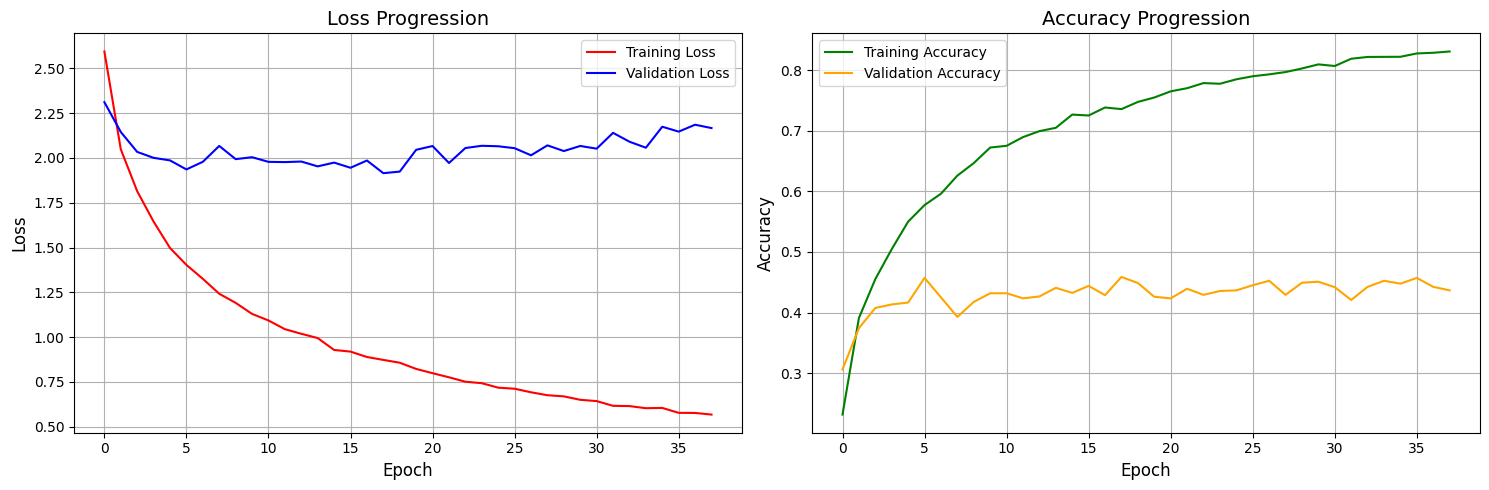

In [77]:
scaler = StandardScaler()
training_features = scaler.fit_transform(training_features)
validation_features = scaler.transform(validation_features)

model = build_model(input_features=training_features.shape[1],
                    hidden_layers=[128,64,32],
                    learning_rate=0.0005)

early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("/content/drive/My Drive/Final-Year-Project/Dataset/Project-V4/feature-extraction/NotAnnotated/AveragePooled/6s_all_features_best_model.keras", monitor="val_loss", save_best_only=True)

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=100,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=0,
    callbacks=[early_stop, model_checkpoint]
)

visualize(history)

In [78]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['all_features'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['all_features'] = model.evaluate(validation_features, val_y)[-1]

223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8690 - loss: 0.5099
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4666 - loss: 1.8493


### **With MFCCs only**

In [79]:
training_features = train_features['mfcc']

training_features.shape

(7105, 20)

In [80]:
validation_features = val_features['mfcc']

validation_features.shape

(1896, 20)

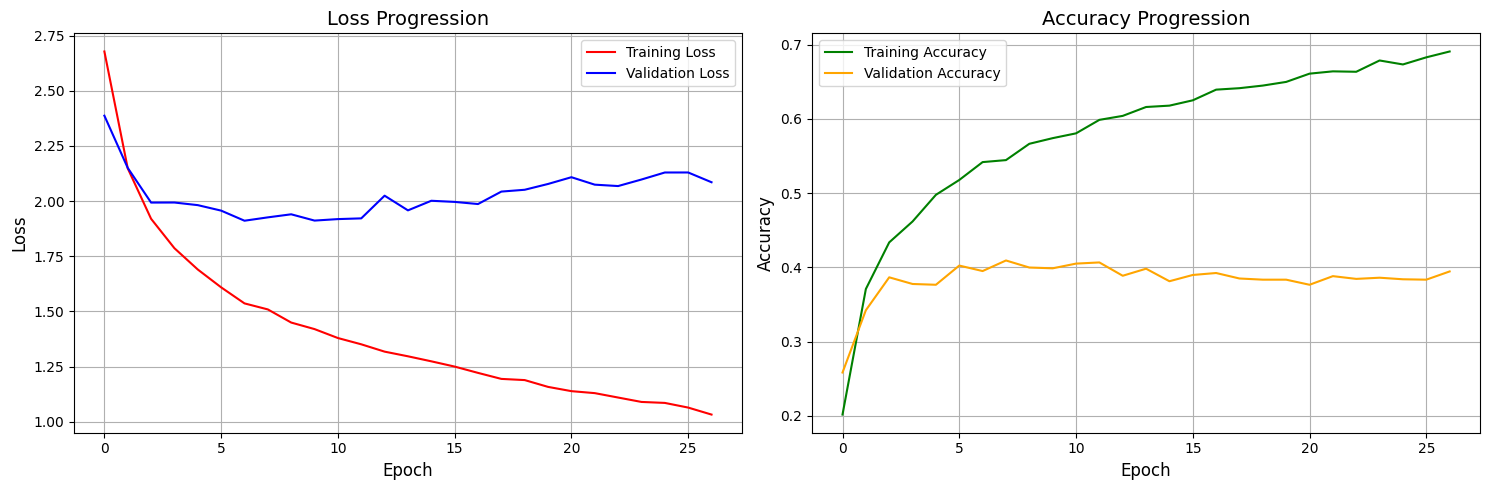

In [81]:
scaler = StandardScaler()
training_features = scaler.fit_transform(training_features)
validation_features = scaler.transform(validation_features)

model = build_model(input_features=training_features.shape[1],
                    hidden_layers=[128,64,32],
                    learning_rate=0.0005)

early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("/content/drive/My Drive/Final-Year-Project/Dataset/Project-V4/feature-extraction/NotAnnotated/AveragePooled/6s_mfcc_best_model.keras", monitor="val_loss", save_best_only=True)

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=100,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=0,
    callbacks=[early_stop, model_checkpoint]
)

visualize(history)

In [82]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['mfcc'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['mfcc'] = model.evaluate(validation_features, val_y)[-1]

223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6373 - loss: 1.2424
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3997 - loss: 1.8662


## **With MFCCs and Mel-Spectrogram**

In [83]:
training_features = np.concatenate((train_features['mfcc'], train_features['melspectrogram']), axis=1)

training_features.shape

(7105, 80)

In [84]:
validation_features = np.concatenate((val_features['mfcc'], val_features['melspectrogram']), axis=1)

validation_features.shape

(1896, 80)

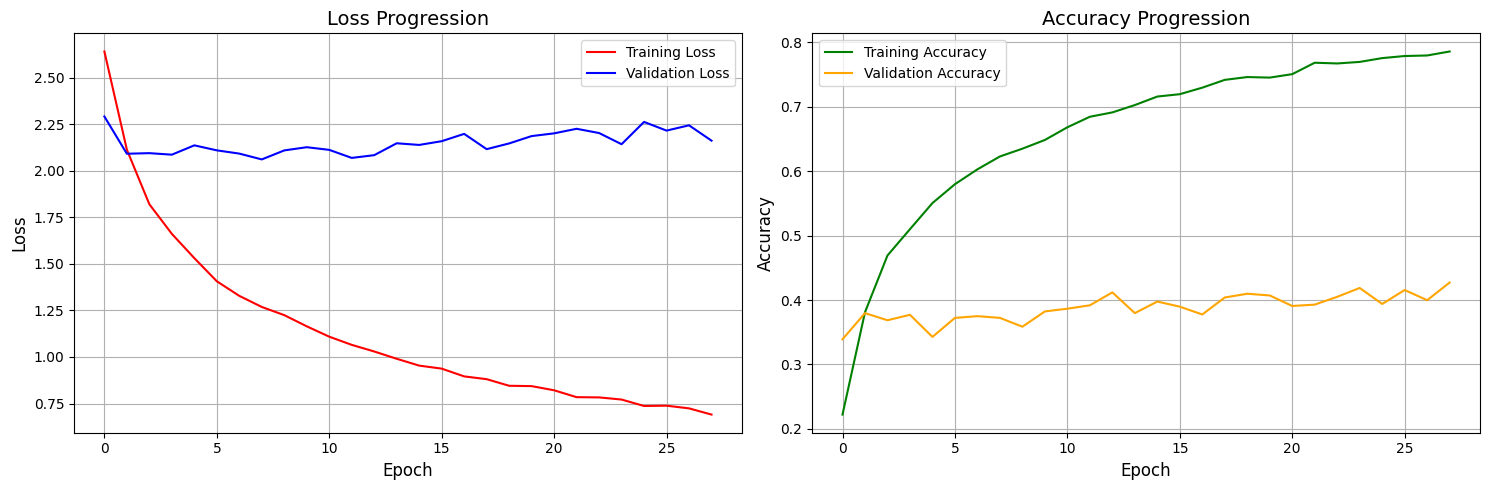

In [85]:
scaler = StandardScaler()
training_features = scaler.fit_transform(training_features)
validation_features = scaler.transform(validation_features)

model = build_model(input_features=training_features.shape[1],
                    hidden_layers=[128,64,32],
                    learning_rate=0.0005)

early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("/content/drive/My Drive/Final-Year-Project/Dataset/Project-V4/feature-extraction/NotAnnotated/AveragePooled/6s_mfcc_melspectrogram_best_model.keras", monitor="val_loss", save_best_only=True)

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=100,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=0,
    callbacks=[early_stop, model_checkpoint]
)

visualize(history)

In [86]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['mfcc_melspectrogram'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['mfcc_melspectrogram'] = model.evaluate(validation_features, val_y)[-1]

223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7580 - loss: 0.8820
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3739 - loss: 1.9780


## **With MFCCs and Chroma**

In [87]:
training_features = np.concatenate((train_features['mfcc'], train_features['chroma']), axis=1)

training_features.shape

(7105, 32)

In [88]:
validation_features = np.concatenate((val_features['mfcc'], val_features['chroma']), axis=1)

validation_features.shape

(1896, 32)

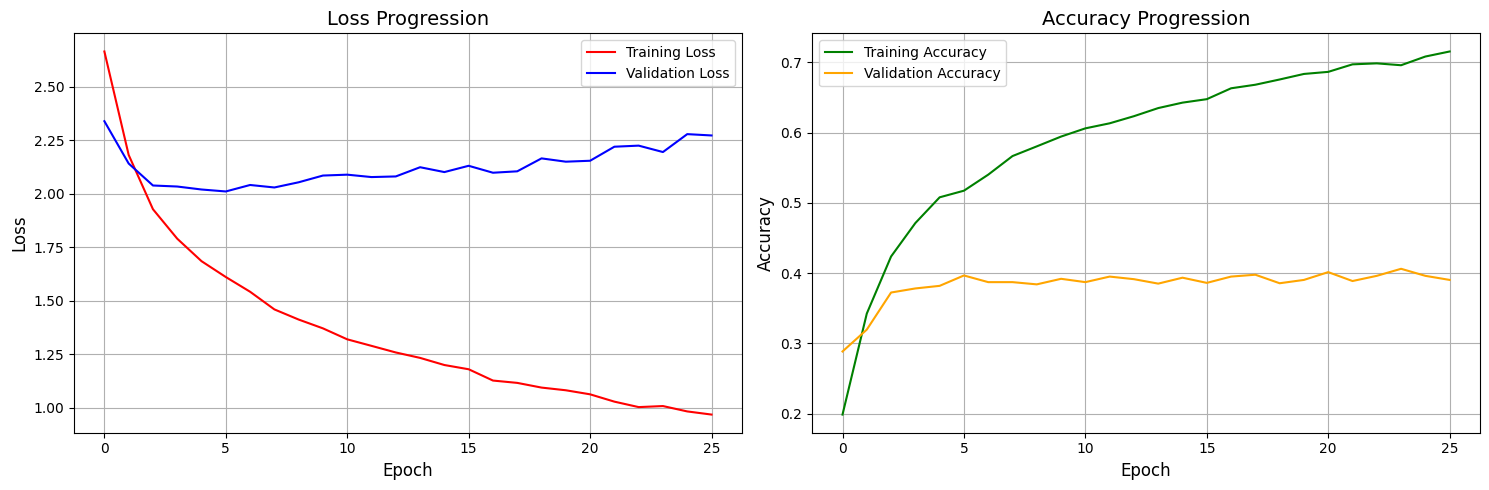

In [89]:
scaler = StandardScaler()
training_features = scaler.fit_transform(training_features)
validation_features = scaler.transform(validation_features)

model = build_model(input_features=training_features.shape[1],
                    hidden_layers=[128,64,32],
                    learning_rate=0.0005)

early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("/content/drive/My Drive/Final-Year-Project/Dataset/Project-V4/feature-extraction/NotAnnotated/AveragePooled/6s_mfcc_chroma_best_model.keras", monitor="val_loss", save_best_only=True)

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=100,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=0,
    callbacks=[early_stop, model_checkpoint]
)

visualize(history)

In [90]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['mfcc_chroma'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['mfcc_chroma'] = model.evaluate(validation_features, val_y)[-1]

223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6276 - loss: 1.2681
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3927 - loss: 1.9687


## **With MFCCs and RMS**

In [91]:
training_features = np.concatenate((train_features['mfcc'], train_features['rms']), axis=1)

training_features.shape

(7105, 21)

In [92]:
validation_features = np.concatenate((val_features['mfcc'], val_features['rms']), axis=1)

validation_features.shape

(1896, 21)

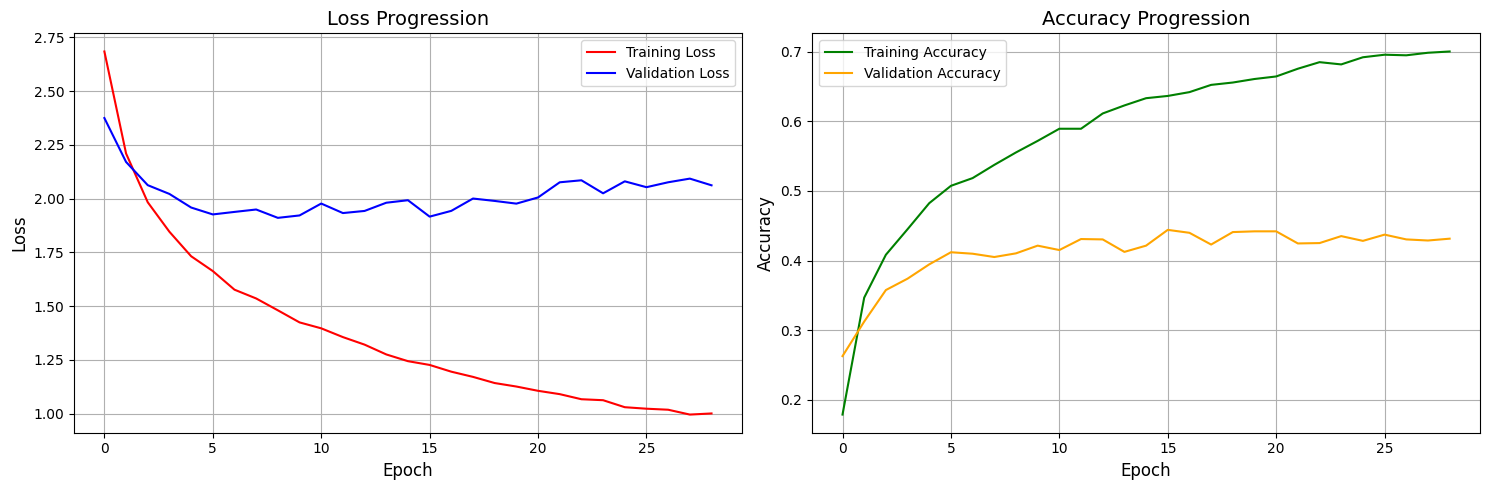

In [93]:
scaler = StandardScaler()
training_features = scaler.fit_transform(training_features)
validation_features = scaler.transform(validation_features)

model = build_model(input_features=training_features.shape[1],
                    hidden_layers=[128,64,32],
                    learning_rate=0.0005)

early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("/content/drive/My Drive/Final-Year-Project/Dataset/Project-V4/feature-extraction/NotAnnotated/AveragePooled/6s_mfcc_rms_best_model.keras", monitor="val_loss", save_best_only=True)

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=100,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=0,
    callbacks=[early_stop, model_checkpoint]
)

visualize(history)

In [94]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['mfcc_rms'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['mfcc_rms'] = model.evaluate(validation_features, val_y)[-1]

223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6684 - loss: 1.1614
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4091 - loss: 1.8719


## **With Mel-Spectrogram, MFCCs, RMS**

In [95]:
training_features = np.concatenate((train_features['melspectrogram'], train_features['rms'], train_features['mfcc']), axis=1)

training_features.shape

(7105, 81)

In [96]:
validation_features = np.concatenate((val_features['melspectrogram'], val_features['rms'], val_features['mfcc']), axis=1)

validation_features.shape

(1896, 81)

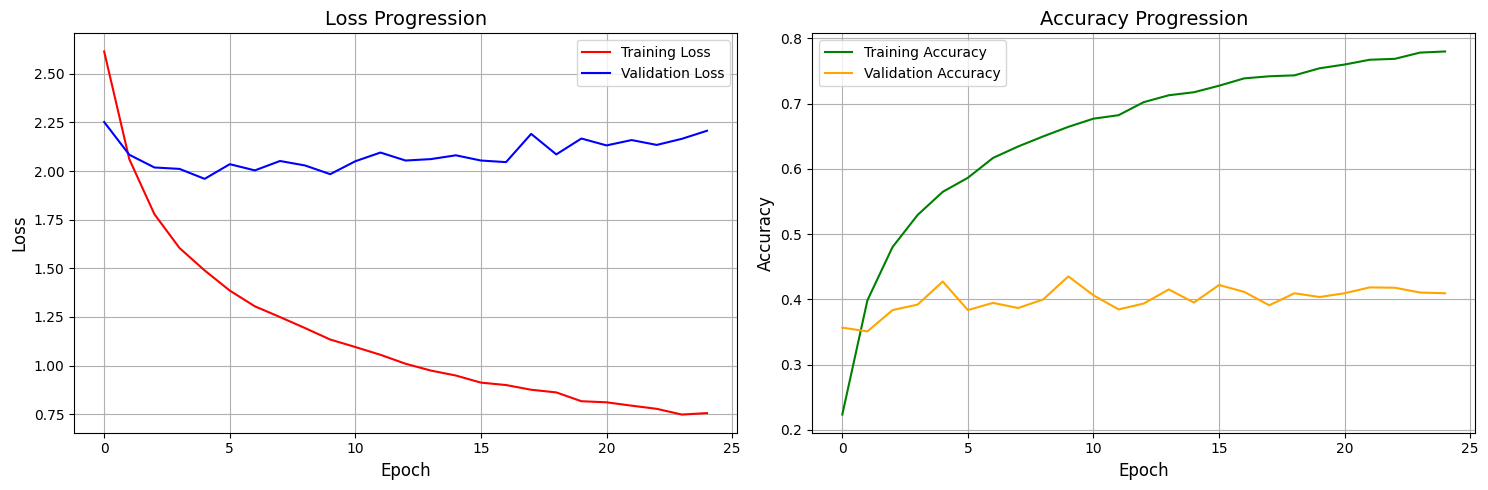

In [97]:
scaler = StandardScaler()
training_features = scaler.fit_transform(training_features)
validation_features = scaler.transform(validation_features)

model = build_model(input_features=training_features.shape[1],
                    hidden_layers=[128,64,32],
                    learning_rate=0.0005)

early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("/content/drive/My Drive/Final-Year-Project/Dataset/Project-V4/feature-extraction/NotAnnotated/AveragePooled/6s_melspectrogram_rms_mfcc_best_model.keras", monitor="val_loss", save_best_only=True)

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=100,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=0,
    callbacks=[early_stop, model_checkpoint]
)

visualize(history)

In [98]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['melspectrogram_rms_mfcc'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['melspectrogram_rms_mfcc'] = model.evaluate(validation_features, val_y)[-1]

223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6874 - loss: 1.1332
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4460 - loss: 1.8846


## **With Mel-Spectrogram, MFCCs, Chroma**

In [99]:
training_features = np.concatenate((train_features['melspectrogram'], train_features['chroma'], train_features['mfcc']), axis=1)

training_features.shape

(7105, 92)

In [100]:
validation_features = np.concatenate((val_features['melspectrogram'], val_features['chroma'], val_features['mfcc']), axis=1)

validation_features.shape

(1896, 92)

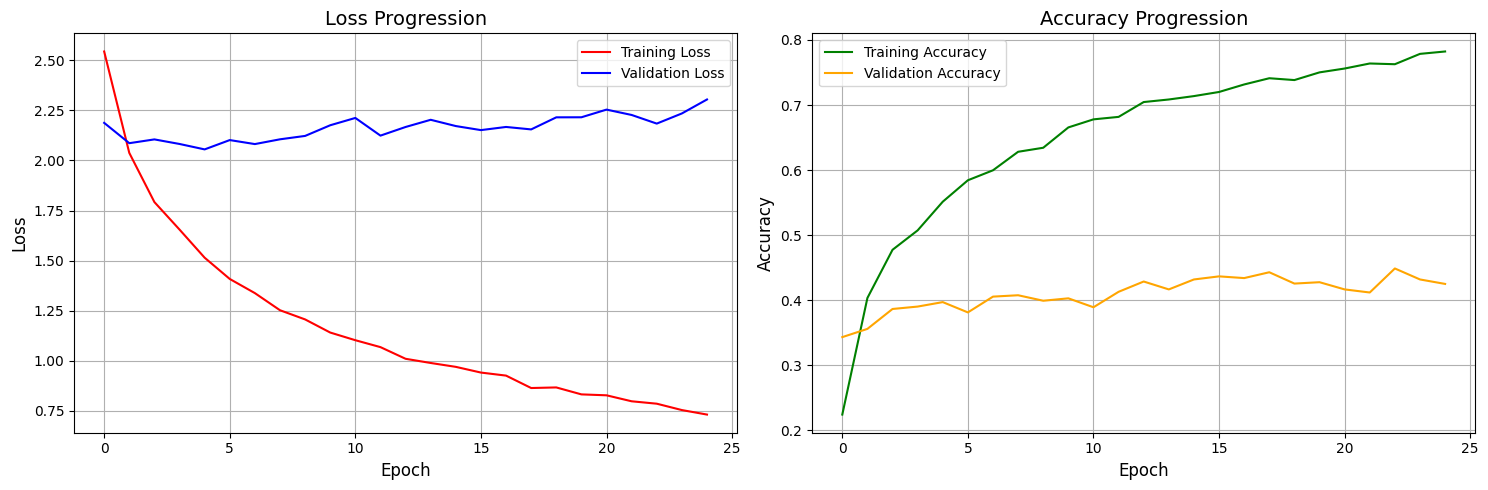

In [101]:
scaler = StandardScaler()
training_features = scaler.fit_transform(training_features)
validation_features = scaler.transform(validation_features)

model = build_model(input_features=training_features.shape[1],
                    hidden_layers=[128,64,32],
                    learning_rate=0.0005)

early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("/content/drive/My Drive/Final-Year-Project/Dataset/Project-V4/feature-extraction/NotAnnotated/AveragePooled/6s_melspectrogram_chroma_mfcc_best_model.keras", monitor="val_loss", save_best_only=True)

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=100,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=0,
    callbacks=[early_stop, model_checkpoint]
)

visualize(history)

In [102]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['melspectrogram_chroma_mfcc'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['melspectrogram_chroma_mfcc'] = model.evaluate(validation_features, val_y)[-1]

223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6867 - loss: 1.1496
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4073 - loss: 1.9801


# Review results from all models

In [103]:
train_results_df = pd.DataFrame(list(train_results.items()), columns=['Features', 'Train_Accuracy']).round(2)
val_results_df = pd.DataFrame(list(val_results.items()), columns=['Features', 'Val_Accuracy']).round(2)

result_df = train_results_df.merge(val_results_df, on='Features')
result_df = result_df.sort_values('Features')
result_df

,Features,Train_Accuracy,Val_Accuracy
0,all_features,0.87,0.46
6,melspectrogram_chroma_mfcc,0.69,0.40
5,melspectrogram_rms_mfcc,0.70,0.43
1,mfcc,0.64,0.40
3,mfcc_chroma,0.64,0.40
2,mfcc_melspectrogram,0.76,0.37
4,mfcc_rms,0.67,0.41
